In [2]:
#import statements
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
from tabulate import tabulate

ModuleNotFoundError: No module named 'numpy'

In [ ]:
class MFO:
    #Initializes the MFO class with parameters =
    #'max_iteration', 'number_of_moths', fitnessfunction', #and 'dimension'
    def __init__(self, max_iteration, number_of_moths, fitnessfunction, dimension = 0, *args, **kwargs):

        # This parameter represents the dimensionality of the problem space, which indicates the number of variables in the optimization problem
        self.dimension = dimension

        # This sets the maximum number of iterations of the algorithm will run before terminating
        self.max_iteration = max_iteration

        # This determines the population size or the number of moths in the algorithm
        self.number_of_moths = number_of_moths

        self.fitnessfunction_name = fitnessfunction
        self.is_valid()





    #Checks if the input parameters are of the correct types- Error handling
    def is_valid(self):
        if not isinstance(self.fitnessfunction_name, str):
            sys.exit("fitnessfunction must be string")
        if not isinstance(self.dimension, int):
            sys.exit("dimension must be integer")
        if not isinstance(self.max_iteration, int):
            sys.exit("max_iteration must be integer")
        if not isinstance(self.number_of_moths, int):
            sys.exit("number_of_moths must be integer")




    #Gets the fitness function based on the provided name and sets dimensions and bounds
    def get_fitnessfunction(self):

        # Create an instance of the FitnessFunctions class
        FitnessFunctions_object = FitnessFunctions()

        # Retrieve the fitness function and its arguments based on the provided name
        fitnessfunction_args, self.fitnessfunction = FitnessFunctions_object.get(self.fitnessfunction_name)

        # Update dimension, lower bound, and upper bound based on the fitness function arguments
        self.dimension = fitnessfunction_args['dim'] if fitnessfunction_args['dim'] else self.dimension
        self.lower_bound = fitnessfunction_args['lb']
        self.upper_bound = fitnessfunction_args['ub']

        # If lower bound is not a list, create a list with the same value for each dimension
        if not isinstance(self.lower_bound, list):
            self.lower_bound = [self.lower_bound for i in range(self.dimension)]

        # If upper bound is not a list, create a list with the same value for each dimension
        if not isinstance(self.upper_bound, list):
            self.upper_bound = [self.upper_bound for i in range(self.dimension)]


    # Initializes the positions of moths within the specified bounds
    def determine_the_initial_position_of_the_moths(self):
        # Initialize the position_of_moths array with zeros for all moths and dimensions
        self.position_of_moths = np.zeros((self.number_of_moths, self.dimension))


        # Loop through each dimension
        for i in range(self.dimension):

            # Generate random numbers uniformly between 0 and 1 for each moth
            self.position_of_moths[:,i] = (
                                np.random.uniform(0, 1, self.number_of_moths) *\
                                (self.upper_bound[i] - self.lower_bound[i]) +\
                                self.lower_bound[i]
                            )


        # Store the initial position_of_moths for alter reference
        self.initial_position_of_moths = self.position_of_moths





    #Initializes the fitness values of moths
    def determine_the_initial_value_of_the_moths(self):
        self.fitness_of_moths = np.full(self.number_of_moths, float("inf"))






    #Sorts the moths based on their fitness values
    def sort_the_first_fitness_of_moths(self):
        self.fitness_sorted = np.sort(self.fitness_of_moths)


        # Get the indices of the moths in sorted fitness
        I = np.argsort(self.fitness_of_moths)
        self.sorted_population = self.position_of_moths[I,:]





    #Determines the number of flames for each iteration
    def determine_the_number_of_flames(self, iteration):
        return round(self.number_of_moths - iteration * ((self.number_of_moths-1) / self.max_iteration))




    #Updates moth positions based on the flame positions
    def update_the_position_of_moths(self, iteration):
        number_of_flames = self.determine_the_number_of_flames(iteration)
        a = -1 + iteration * ((-1) / self.max_iteration) # a linearly decrease in range [-2, -1] to calculate "t" in Eq. (3.12)
        for i in range(0, self.number_of_moths):
            for j in range(0, self.dimension):
                distance_to_flame = abs(
                    self.sorted_population[i,j] - self.position_of_moths[i,j]
                )  # D in Eq. (3.13)
                b = 1
                t = (a - 1) * random.random() + 1
                if i <= number_of_flames: # Update the position of the moth with respect to its corresponding flame
                    #Eq. (3.12)
                    self.position_of_moths[i,j] = (
                                                distance_to_flame *\
                                                np.exp(b * t) *\
                                                np.cos(t * 2 * np.pi) +\
                                                self.sorted_population[i,j]
                                            )
                if i > number_of_flames: # Update the position of the moth with respect to one flame
                    #Eq. (3.12)
                    self.position_of_moths[i,j] = (
                                                distance_to_flame *\
                                                np.exp(b * t) *\
                                                np.cos(t*2*np.pi) +\
                                                self.sorted_population[number_of_flames,j]
                                            )




    #Update fitness flames for each iteration
    def update_the_fitness_of_flames(self, iteration, moths_family_sorted):

        # Check if it's the first iteration
        if iteration == 1:

            # If it's the first iteration, sort the fitness of moths
            self.sort_the_first_fitness_of_moths()


        # If it's not the first iteration:
        else:


            # Concatenate parent moths and best flames along the rows
            moths_family = np.concatenate(
                            (self.parent_moths, self.best_flames),
                            axis = 0
                        )


            # Concatenate fitness values of parent moths and best flames
            fitness_of_moths_family = np.concatenate(
                            (self.fitness_of_parent_moths, self.fitness_of_best_flames),
                            axis = 0
                        )

            # Sort the concatenated fitness values
            fitness_of_moths_family_sorted = np.sort(fitness_of_moths_family)


            # Get the indices that would sort the fitness values
            I2 = np.argsort(fitness_of_moths_family)



            # Iterate over the rnage of twice the number of moths
            for newindex in range(0, 2 * self.number_of_moths):

                # Reorder the moths based on the sorterd indices
                moths_family_sorted[newindex,:] = np.array(moths_family[I2[newindex],:])


            # Store the sorted fitness values of moths for the current iteration
            self.fitness_sorted = fitness_of_moths_family_sorted[0:self.number_of_moths]


            # Store the sorted moths for the current iteration
            self.sorted_population = moths_family_sorted[0:self.number_of_moths, :]





    #Determines the best flames for the moth
    def determine_the_best_flames(self):
        self.best_flames = self.sorted_population
        self.fitness_of_best_flames = self.fitness_sorted





    #Ensures positions are within search space bounds
    def valid_the_position_of_moths_to_search_space(self):
        for i in range(self.number_of_moths):
            for j in range(self.dimension):
                self.position_of_moths[i,j] = np.clip(
                                            self.position_of_moths[i,j],
                                            self.lower_bound[j],
                                            self.upper_bound[j]
                                        )





    #Evaluates the fitness of moths using the fitness function
    def evaluate_the_moths(self):
        for i in range(self.number_of_moths): self.fitness_of_moths[i] = self.fitnessfunction(self.position_of_moths[i,:])






    #Main funciton to start the optimization process
    def start(self):
        self.get_fitnessfunction()
        self.determine_the_initial_position_of_the_moths()
        self.determine_the_initial_value_of_the_moths()
        self.convergence_curve = np.zeros(self.max_iteration)
        moths_family_sorted = np.zeros((2 * self.number_of_moths, self.dimension))
        self.report = list()
        iteration = 1
        while not iteration > self.max_iteration:
            self.parent_moths = self.position_of_moths
            self.fitness_of_parent_moths = self.fitness_of_moths
            self.valid_the_position_of_moths_to_search_space()
            self.evaluate_the_moths()
            self.update_the_fitness_of_flames(iteration, moths_family_sorted)
            self.determine_the_best_flames()
            self.update_the_position_of_moths(iteration)
            self.convergence_curve[iteration - 1] = self.fitness_sorted[0]
            temp = [self.fitness_sorted[0]]
            for position in self.sorted_population[0]:
                temp.append(position)
            self.report.append(temp)
            iteration += 1






    #Draws a plot of the convergence curve
    def draw_the_plot(self):
        # Data for plotting
        plot.plot(np.arange(1, self.max_iteration + 1), self.convergence_curve)
        plot.xlabel('Iteration')
        plot.ylabel('Cost')
        plot.title('Fitness Function Values in Iterations')
        plot.show()





    #Gets the opitimization report
    def get_report(self):
        self.header = ['Score',]
        self.header.extend(range(self.dimension))
        return self.header, self.report

In [ ]:
class FitnessFunctions:

    #Gets a lists of available fitness function names
    def get_functions_name(self):
        names = self.args('all')
        return names

    #Gets names of fitness functions that work in n-dimensional space
    def get_n_dimension_functions_name(self):
        names = self.args("n_dimension")
        return names

    #Gets the details and actual function for a given fitness function name
    def get(self, name):
        try:
            return self.args(name), getattr(self, name)
        except AttributeError:
            sys.exit('There is no function named "{}"'.format(name))

    #Defines details of various fitness functions
    def args(self, name):           # dim == dimension, lb == lower bound, ub == upper bound
        args = {
            # 'function_name': {
            #   'dim': value,
            #   'lb': value,
            #   'ub': value
            # }
              'f1': {
                'dim': 100,
                'lb': -100,
                'ub': 100
            },

              'f2': {
                'dim': 100,
                'lb': -10,
                'ub': 10
            },

              'f3': {
                'dim': 100,
                'lb': -100,
                'ub': 100
            },

              'f4': {
                'dim': 100,
                'lb': -100,
                'ub': 100
            },

              'f5': {
                'dim': 100,
                'lb': -30,
                'ub': 30
            },

              'f6': {
                'dim': 100,
                'lb': -100,
                'ub': 100
            },

              'f7': {
                'dim': 100,
                'lb': -1.28,
                'ub': 1.28
            },

              'f8': {
                'dim': 100,
                'lb': -500,
                'ub': 500
            },


              'f9': {
                'dim': 100,
                'lb': -5.12,
                'ub': 5.12
            },
              'f10': {
                'dim': 100,
                'lb': -32,
                'ub': 32
            },

              'f11': {
                'dim': 100,
                'lb': -600,
                'ub': 600
            },
        }

        if name == 'all':
            return list(args.keys())
        if name == 'n_dimension':
            return list(filter(lambda key: args[key]['dim'] == 0, args.keys()))
        details = args.get(name)
        if details:
            result = {
                'dim': details['dim'],
                'lb': details['lb'],
                'ub': details['ub']
            }
            return result
        else:
            sys.exit('There is no function named "{}"\'s details'.format(name))

    def f1(self, value):
      return np.sum(value ** 2)

    def f2(self, value):
      return np.sum(abs(value)) + np.prod(abs(value))

    def f3(self, value):
      result = 0
      for i in range(1, len(value)):
        result += np.sum(value[0:i])**2
      return result

    def f4(self, value):
      return np.max(abs(value))

    def f5(self, value):
      result = 0
      for i in range(0,len(value)-1):
        result += (100 * (value[i+1] - value[i]**2)**2 + (value[i] - 1)**2)
      return result

    def f6(self, value):
      return np.sum((value + 0.5)**2)

    def f7(self, value):
      result = 0
      for i in range(0,len(value)):
        result += ((i+1)*value[i]**4)
      result += random.random()
      return result

    def f8(self,value):
      return np.sum((-1 * value * np.sin(np.sqrt(abs(value)))))

    def f9(self,value):
      return np.sum(value**2 - (10 * np.cos(2*value*np.pi)) + 10)

    def f10(self, value):
      result = -20*np.exp(-0.2*np.sqrt((np.sum(np.square(value)))/len(value)))
      result -= np.exp(np.sum(np.cos(2*np.pi*value))/len(value))
      result += 20 + np.exp(1)
      return result

    def f11(self, value):
      result = np.sum(np.square(value))/4000 + 1
      prod = 1
      for i in range(0,len(value)):
        prod *= np.cos(value[i]/np.sqrt(i+1))
      result -= prod
      return result

1-f1
 2-f2
 3-f3
 4-f4
 5-f5
 6-f6
 7-f7
 8-f8
 9-f9
 10-f10
 11-f11
Choose your fitness function iD: 1
Enter the Max iteration: 500
Enter the number of moths: 30


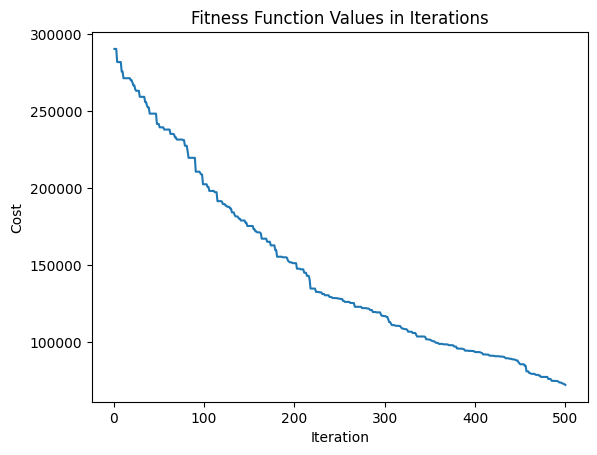

Moth-Flame Optimization Algorithm Report


Fitness Function: f1


Moth's Position Domain: [-100, 100]


Moth's Position Dimension: 100-dimensional space


Number of Iteration: 500



Initial Position of Moths

-------  ----------  -------  ---------  -------  --------  -------  ------------  -------  ----  --------  ---------  ----------  --------  --------  --------  --------  --------  ---------  -------  --------  ---------  -------  -------  --------  -----------  -------  --------  --------  -------  --------  --------  ---------  -------  ---------  ----------  --------  --------  --------  -------  ---  -------  -------  ---------  ---------  --------  ---------  -------  ---  ---------  --------  ----------  ----------  --------  --------  -------  -------  ----------  ---------  ---------  --------  -------  ----------  --------  ---------  --------  --------  ----------  ---------  --------  ---------  --------  --------  ---------  -------  ---  ---------  ---------  -------

In [ ]:
# Main function
def main():

    # Creating an instance of the FitnessFunctions class
    FitnessFunctions_object = FitnessFunctions()



    # Getting the name of fitness functions with their respective dimensions
    n_dimension = get_n_dimension_functions_name(FitnessFunctions_object)





    # Getting the name of the fitness function from the user
    fitness_function_name = get_function_name(FitnessFunctions_object)




    # Getting the maximum number of iterations for the optimization algorithm
    max_iteration = get_max_iteration()



    # Getting the number of moths (population size) for the optimization algorithm
    number_of_moths = get_number_of_moths()



    # If we were given a dimension then excecute this code
    if fitness_function_name in n_dimension :

                # Getting the dimension from the user
                dimension = get_dimension()


                # Creating an instance of the Moth Flame Optimization (MFO) algorithm with dimension specified
                mfo_object = MFO(
                            max_iteration,
                            number_of_moths,
                            dimension = dimension,
                            fitnessfunction = fitness_function_name
                        )




    # Else if we were not given a dimension then excecute this part
    else:

        # Creating an instnace of the MFO algorithm without dimension specified
        mfo_object = MFO(
                    max_iteration,
                    number_of_moths,
                    fitnessfunction = fitness_function_name
                )

    # Starting the optmization process
    mfo_object.start()


    # Getting the initial position of moths after optimization
    initial_position_of_moths = mfo_object.initial_position_of_moths


    #Getting the report header and report of the MFO algorithm
    mfo_report_header, mfo_report = mfo_object.get_report()



    # Drawing the plot of the optmization process
    mfo_object.draw_the_plot()



    # Writing the optimization report ot a file
    write_the_report(
            mfo_report_header,
            mfo_report,
            max_iteration,
            fitness_function_name,
            mfo_object.dimension,
            mfo_object.lower_bound[0],
            mfo_object.upper_bound[0],
            initial_position_of_moths
        )
    print('SUCCESSFUL!')

#Writes a report on the optimization process
def write_the_report(
        header,
        report,
        max_iteration,
        fitness_function_name,
        fitness_function_dimension,
        fitness_function_lower_bound,
        fitness_function_upper_bound,
        initial_position_of_moths
    ):

    print('Moth-Flame Optimization Algorithm Report\n\n')
    print('Fitness Function: {}\n\n'.format(fitness_function_name))
    print(
        'Moth\'s Position Domain: [{}, {}]\n\n'.format(
                                                fitness_function_lower_bound,
                                                fitness_function_upper_bound
                                            )
    )
    print('Moth\'s Position Dimension: {}-dimensional space\n\n'.format(fitness_function_dimension))
    print('Number of Iteration: {}\n\n\n'.format(max_iteration))
    print('Initial Position of Moths\n')
    print(
        tabulate(
            initial_position_of_moths
        )
    )
    print('\n\n\nBest moth\'s score and position in each iteration:\n')
    print(
        tabulate(
            report,
            headers = header,
            tablefmt = "fancy_grid",
            showindex = range(1, max_iteration + 1),
            colalign = ("center",) * (len(header) + 1),
        )
    )

def get_function_name(obj):
    names = [(i+1, name) for i, name in enumerate(obj.get_functions_name())]

    try:
        choice = int(
            input(' '.join(
                        map(
                            str,
                            [str(name[0])+'-{}\n'.format(name[1]) for name in names]
                        )
                    ) +\
                'Choose your fitness function iD: '
            )
        )
        if not choice in range(1, len(names)+1) : sys.exit('Not valid iD.Please enter valid iD')
        fitness_function_name = list(filter(lambda name: name[0] == choice, names))[0][1]
        return fitness_function_name

    except (ValueError, NameError, SyntaxError):               # raise error message if choice is not integer and exit
        sys.exit('Not an integer! Please enter an integer.')

def get_n_dimension_functions_name(obj):
    return obj.get_n_dimension_functions_name()

def get_max_iteration():

    try:
        return int(input('Enter the Max iteration: '))
    except (ValueError, NameError, SyntaxError):
        sys.exit('Not an integer! Please enter an integer Max iteration.')

def get_number_of_moths():
    try:
        return int(input('Enter the number of moths: '))
    except (ValueError, NameError, SyntaxError):
        sys.exit('Not an integer! Please enter an integer number of Moths.')

def get_dimension():
    try:
        dimension = int(input('Enter the dimension: '))
        while dimension < 1:
          print("Sorry, no numbers below one")
          dimension = int(input('Enter the dimension: '))
        return dimension
    except (ValueError, NameError, SyntaxError):
        sys.exit('Not an integer! Please enter an integer dimension.')

# Tell python to run main method
if __name__ == "__main__": main()